# Traktor Tracking - Backazimuth

In [1]:
import os,sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from functions.compute_backazimuth import __compute_backazimuth

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [4]:
sys.path.append(root_path+"andbro_python/")

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

## Configurations

In [5]:
config = {}

## BSPF coordinates
config['ROMY_lon'] = -116.455439
config['ROMY_lat'] = 33.610643

config['tbeg'] = obs.UTCDateTime("2023-08-04 09:00")
config['tend'] = obs.UTCDateTime("2023-08-04 14:00")

##
config['path_to_sds'] = archive_path+"romy_archive/"

config['fmin'], config['fmax'] = 5, 25


In [6]:
from andbro__querrySeismoData import __querrySeismoData

In [7]:
rot0, rot_inv = __querrySeismoData(
                                seed_id="BW.ROMY.10.HJZ",
                                starttime=config['tbeg']-10,
                                endtime=config['tend']+10,
                                repository="archive",
                                restitute=False,
                                );
rot0.remove_sensitivity(rot_inv);

In [8]:
acc0, acc_inv = __querrySeismoData(
                                seed_id="BW.DROMY..HH*",
                                starttime=config['tbeg']-10,
                                endtime=config['tend']+10,
                                repository="archive",
                                restitute=False,
                                );

acc0.remove_response(acc_inv, "ACC");

acc0.resample(100);


## Load Data

1 Trace(s) in Stream:
BW.ROMY.10.HJZ | 2023-08-04T09:00:00.001800Z - 2023-08-04T14:00:00.001800Z | 100.0 Hz, 1800001 samples 3 Trace(s) in Stream:
BW.DROMY..HHE | 2023-08-04T09:00:00.000000Z - 2023-08-04T14:00:00.000000Z | 100.0 Hz, 1800001 samples
BW.DROMY..HHN | 2023-08-04T09:00:00.000000Z - 2023-08-04T14:00:00.000000Z | 100.0 Hz, 1800001 samples
BW.DROMY..HHZ | 2023-08-04T09:00:00.000000Z - 2023-08-04T14:00:00.000000Z | 100.0 Hz, 1800001 samples


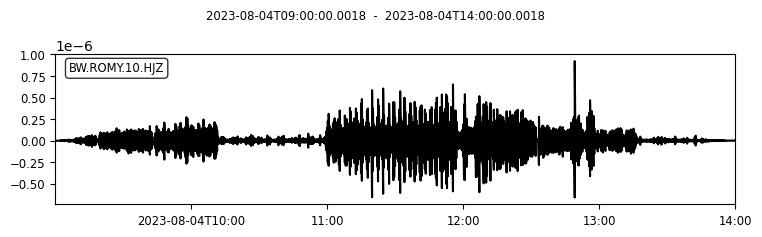

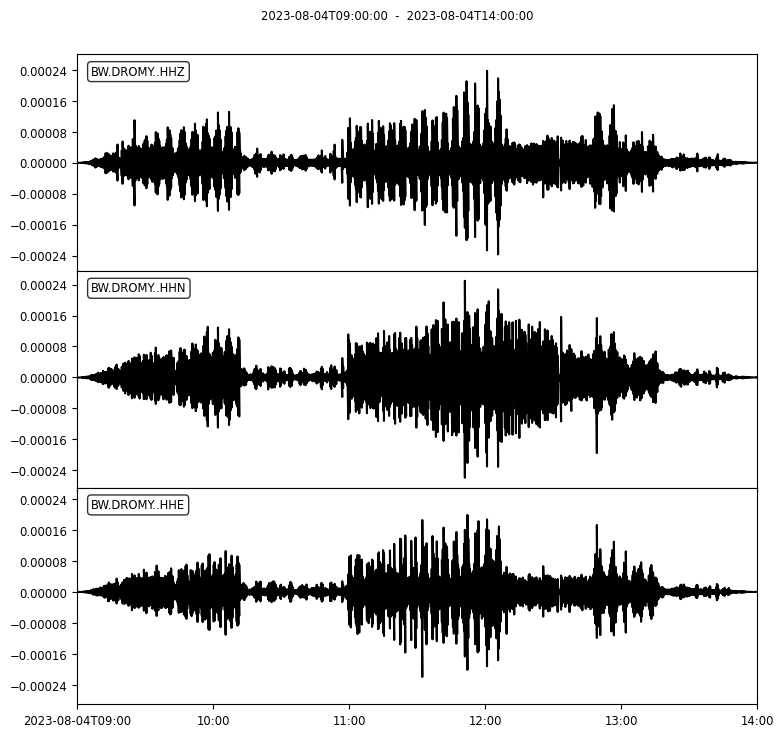

In [9]:
rot = rot0.copy(); acc = acc0.copy();


rot.detrend("linear");
acc.detrend("linear");

rot.taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], zerophase=True, corners=4)
acc.taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], zerophase=True, corners=4)

rot.trim(config['tbeg'], config['tend']);
acc.trim(config['tbeg'], config['tend']);

print(rot, acc)

rot.plot();
acc.plot();

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 



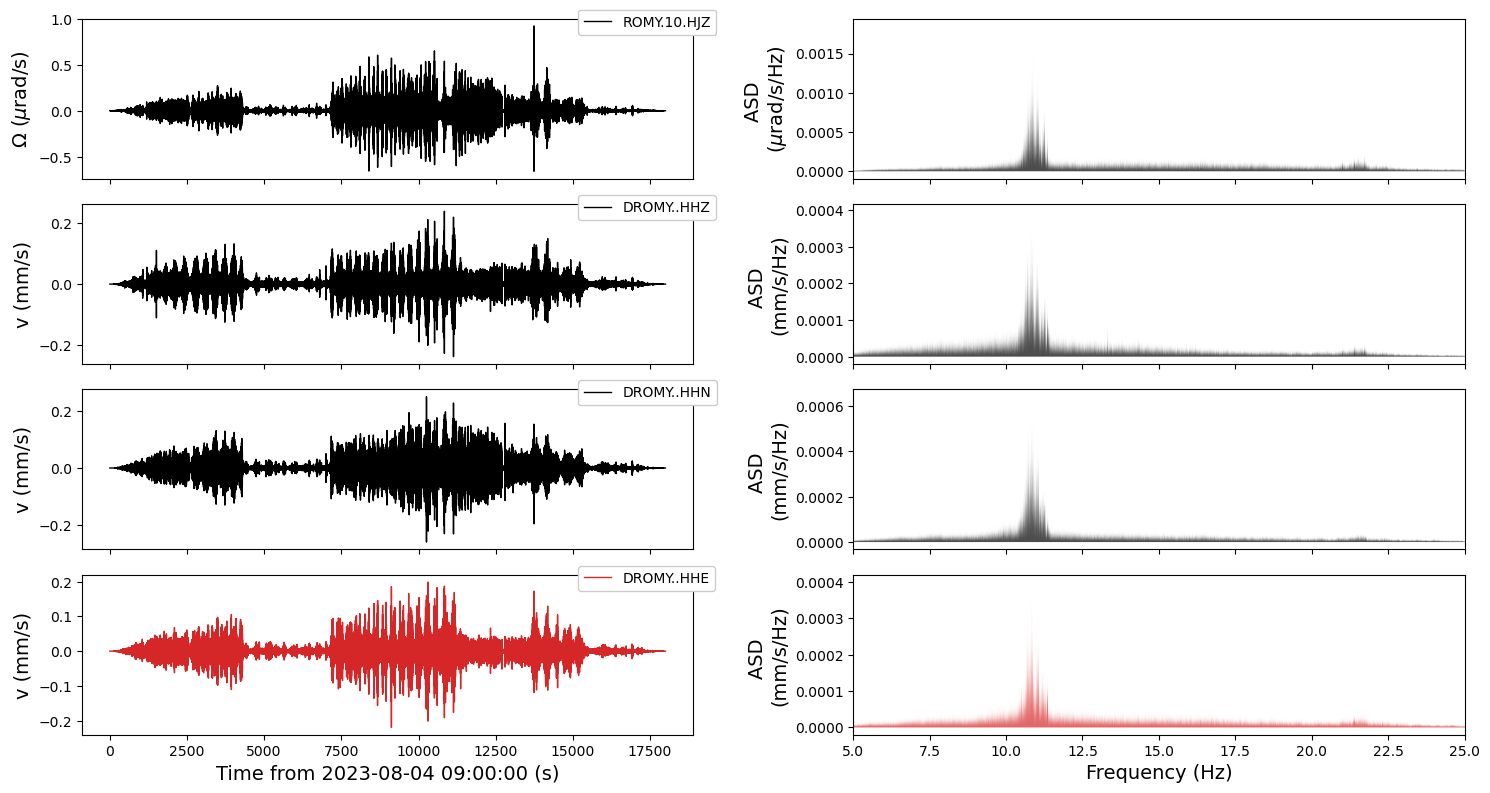

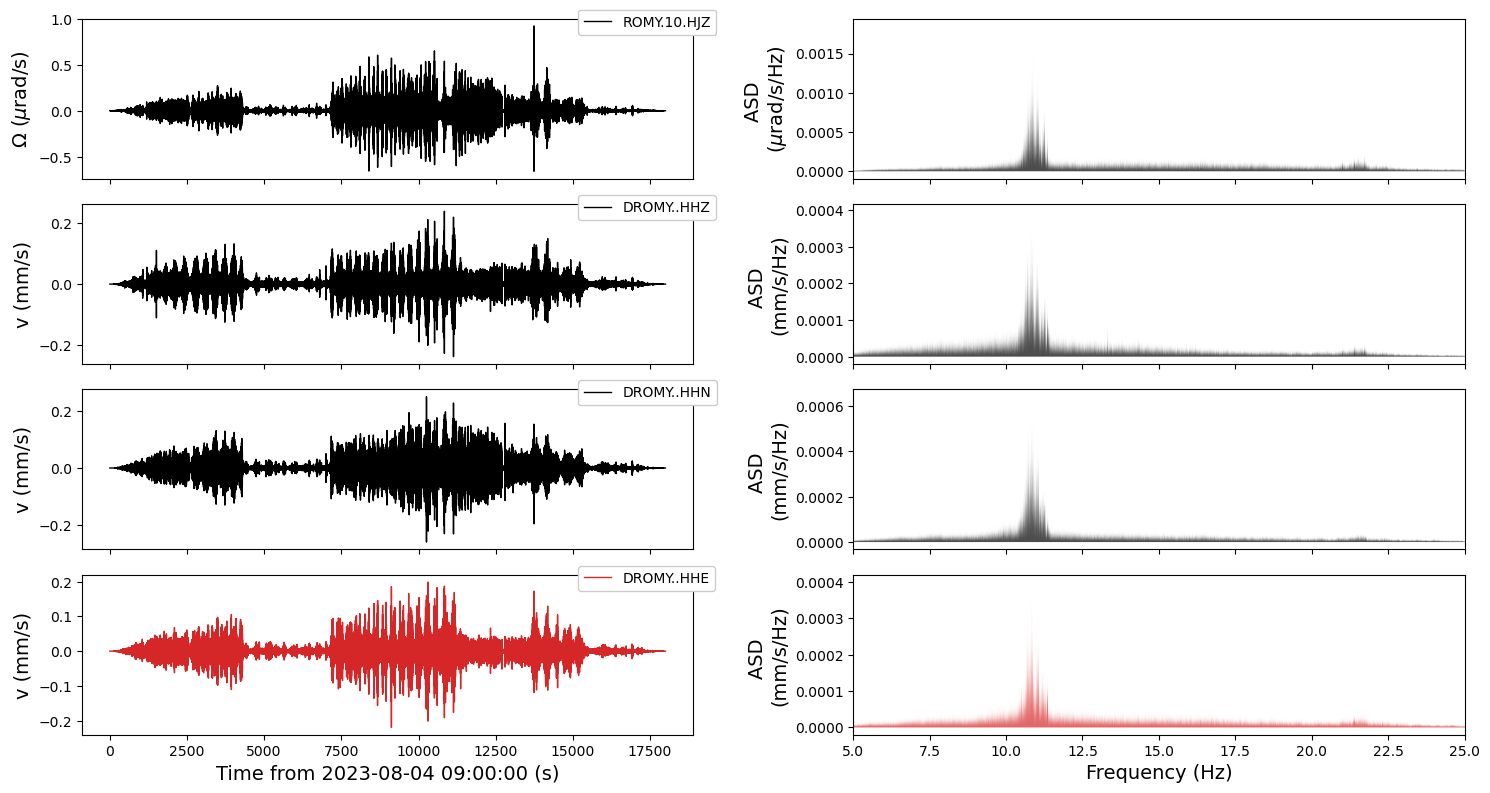

In [10]:
st = rot; st+= acc

from functions.makeplotStream_spectra import __makeplotStreamSpectra

__makeplotStreamSpectra(st, fmin=config['fmin'], fmax=config['fmax'])

## BAZ Estimation

In [12]:
def __compute_backazimuth(st_acc, st_rot, config, wave_type="love", event=None, plot=True, show_details=False):

    """
    This method estimates a backazimuth for either
     - Love waves (vertical rotation rate and transverse acceleration) or
     - Rayleigh waves (vertical acceleration and transverse rotation rate)
    and compares it to a theoretical backazimuth computed from the source and receiver location.


    ARGUMENTS:

    - st_rot:  stream of rotation rate (ideally 3 components with channels *Z,*N,*E)
    - config:  configuration parameters as dictionary. Keywords:
               'tbeg','tend','station_latitude', 'station_longitude', 'step', 'win_length_sec', 'overlap', 'eventtime'
    - wave_type:  "love" or "rayleigh" (default: "love")
    - event:  event obspy object. Default is None. If None USGS catalog is searched for appropriate event.
    - plot:   bool (default: True). Shows plot if set True
    - show_details:  bool (default: False). Shows messages while executing if set True.

    RETURN:
    - out:  dictionary with output data. Keywords:
            'baz_mesh', 'baz_corr', 'baz_theo', 'acc_transverse', 'acc_radial', 'rot_vertical', 'event'

    >>> out = __compute_backazimuth(st_acc, st_rot, config, wave_type="love", event=None, plot=True, show_details=False)

    """

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    from numpy import ones, arange, linspace, asarray, array, meshgrid, round, shape
    from pprint import pprint
    from obspy import read, read_events, UTCDateTime
    from obspy.clients.fdsn import Client
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.signal.cross_correlation import correlate, xcorr_max
    from obspy.signal.rotate import rotate_ne_rt

    ## _______________________________
    ## check config
    keywords=['tbeg','tend','station_latitude', 'station_longitude',
              'step', 'win_length_sec', 'overlap', 'eventtime']

    for key in keywords:
        if key not in config.keys():
            print(f" -> {key} is missing in config!\n")
            pprint(keywords)
            return


    ## _______________________________
    ## Defaults
    if 'win_length_sec' not in config.keys():
        config['win_length_sec'] = .5    ## window length for correlation
    if 'step' not in config.keys():
        config['step'] = 1
    if 'overlap' not in config.keys():
        config['overlap'] = 25


    ## time period
    config['tbeg'], config['tend'] = UTCDateTime(config['tbeg']), UTCDateTime(config['tend'])
    config['eventime'] = UTCDateTime(config['eventtime'])

    ## _______________________________
    ## prepare streams
    ACC = st_acc.copy().trim(config['tbeg'], config['tend'])
    ROT = st_rot.copy().trim(config['tbeg'], config['tend'])

    ## _______________________________
    ## get event if not provided
    if event == "auto":
        try:
            events = Client("USGS").get_events(starttime=config['eventtime']-20, endtime=config['eventtime']+20)
            if len(events) > 1:
                print(f" -> {len(events)} events found!!!")
                print(events)
                event = events[0]
        except:
            print(" -> no event found in USGS catalog")


    ## event location from event info
    if event is not None:
        config['source_latitude'] = event.origins[0].latitude
        config['source_longitude'] = event.origins[0].longitude

        if show_details:
            print(" -> event used for theoretical backazimuth:")
            print(" -> ", event.event_descriptions[0]['type'], ': ',event.event_descriptions[0]['text'] + "\n")


        ## _______________________________
        ## theoretical backazimuth and distance

        config['baz'] = gps2dist_azimuth(
                                        config['source_latitude'], config['source_longitude'],
                                        config['station_latitude'], config['station_longitude'],
                                        )
        if show_details:
            print(f" -> Epicentral distance [m]:       {round(config['baz'][0],1)}")
            print(f" -> Theoretical azimuth [deg]:     {round(config['baz'][1],1)}")
            print(f" -> Theoretical backazimuth [deg]: {round(config['baz'][2],1)}")

    ## _______________________________
    ## backazimuth estimation with Love or Rayleigh waves

    config['sampling_rate'] = int(ROT.select(channel="*Z")[0].stats.sampling_rate)

    config['num_windows'] = len(ROT.select(channel="*Z")[0]) // (int(config['sampling_rate'] * config['win_length_sec']))

    backas = linspace(0, 360 - config['step'], int(360 / config['step']))

    corrbaz = []

    ind = None

    config['num_windows']

    for i_deg in range(0, len(backas)):

        for i_win in range(0, config['num_windows']):

            ## infer indices
            idx1 = int(config['sampling_rate'] * config['win_length_sec'] * i_win)
            idx2 = int(config['sampling_rate'] * config['win_length_sec'] * (i_win + 1))

            ## add overlap
            if i_win > 0 and i_win < config['num_windows']:
                idx1 = int(idx1 - config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
                idx2 = int(idx2 + config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])

            ## prepare traces according to selected wave type
            if wave_type == "love":

                if show_details and i_deg == 0 and i_win == 0:
                    print(f"\n -> using {wave_type} waves for estimation ...")

                ## rotate NE to RT
                R, T = rotate_ne_rt(ACC.select(channel='*N')[0].data,
                                    ACC.select(channel='*E')[0].data,
                                    backas[i_deg]
                                   )

                ## compute correlation for backazimuth
#                 corrbaz0 = xcorr(ROT.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,)
                ccorr = correlate(ROT.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
                                  demean=True, normalize='naive', method='fft')
                xshift, cc_max = xcorr_max(ccorr)

                if xshift != 0:
                    print(f" -> maximal cc not a shift=0: shift={xshift} | cc={cc_max}")

            elif wave_type == "rayleigh":

                if show_details and i_deg == 0 and i_win == 0:
                    print(f"\n -> using {wave_type} waves for estimation ...")

                ## rotate NE to RT
                R, T = rotate_ne_rt(ROT.select(channel='*N')[0].data,
                                    ROT.select(channel='*E')[0].data,
                                    backas[i_deg]
                                   )

                ## compute correlation for backazimuth
                ## vertical acceleration has to be reversed for definition of polarization reasons
                ccorr = correlate(-1*ACC.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
                                  demean=True, normalize='naive', method='fft')
#                 ccorr = correlate(ACC.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
#                                   demean=True, normalize='naive', method='fft')

                xshift, cc_max = xcorr_max(ccorr)

                if xshift != 0:
                    print(f" -> maximal cc not a shift=0: shift={xshift} | cc={cc_max}")

            else:
                print(f" -> unknown mode {wave_type}!")

            corrbaz.append(cc_max)


    corrbaz = asarray(corrbaz)
    corrbaz = corrbaz.reshape(len(backas), config['num_windows'])


    ## extract maxima
    maxcorr = array([backas[corrbaz[:, l1].argmax()] for l1 in range(0, config['num_windows'])])

    ## create mesh grid
    t_win = arange(0, config['win_length_sec']*config['num_windows']+config['win_length_sec'], config['win_length_sec'])
    t_win_center = t_win[:-1]+config['win_length_sec']/2
    mesh = meshgrid(t_win, backas)



    ## _______________________________
    ## Plotting
    def __makeplot():

        ## define figure
        fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ## parameters
        font = 18
        acc_scaling, acc_unit = 1e3, "mm/s$^2$"
        rot_scaling, rot_unit = 1e6, "$\mu$rad/s"

        ## create time axis
        time = linspace(0, len(ACC[0].data)/ACC[0].stats.sampling_rate, len(ACC[0].data))

        ## plot vertical rotation rate
        if wave_type == "love":
            ax[0].plot(time, ROT.select(channel="*Z")[0].data*rot_scaling, label='vertical rotation rate')
            ax[0].set_ylabel(f'vert. rot. rate \n({rot_unit})', fontsize=font)
        elif wave_type == "rayleigh":
            ax[0].plot(time, T*rot_scaling, label='transverse rotation rate')
            ax[0].set_ylabel(f'trans. rot. rate \n({rot_unit})', fontsize=font)


        ## plot transverse acceleration
        if wave_type == "love":
            ax[1].plot(time, T*acc_scaling, 'k',label='transverse acceleration')
            ax[1].set_ylabel(f'transv. acc. \n({acc_unit})', fontsize=font)
        elif wave_type == "rayleigh":
            ax[1].plot(time, ACC.select(channel="*Z")[0].data*acc_scaling, 'k',label='vertical acceleration')
            ax[1].set_ylabel(f'vert. acc. \n({acc_unit})', fontsize=font)


        ## backazimuth estimation plot
        im = ax[2].pcolormesh(t_win, backas, corrbaz[:-1,:], cmap=plt.cm.RdYlGn_r, vmin=-1, vmax=1, shading='auto')

#         ax[2].set_xlim(time[0], time[-1])
        ax[2].set_xlim(t_win[0], t_win[-1])
        ax[2].set_ylim(0, 360)
        ax[2].set_ylabel(u'estimated \n backazimuth (°)', fontsize=font)
        ax[2].set_xlabel('time (s)', fontsize=font)


        ## plot maximal correclation values
        ax[2].plot(t_win_center, maxcorr, '.k')


        if event is not None:
            ## plot theoretical Backazimuth for comparison
            xx = arange(0, config['win_length_sec'] * len(maxcorr) + 1, config['win_length_sec'])
            tba = ones(len(xx)) * config['baz'][2]
            ax[2].plot(xx, tba, lw=1.5, alpha=0.7, color="k", ls="--")


            ## add label for theoretical backazimuth
            baz_label = u'Theor. BAZ = '+str(round(config['baz'][2],0))+'°'
            if config['baz'][2] < 330:
                x_text, y_text = time[int(0.78*len(time))], config['baz'][2]+5
            else:
                x_text, y_text = time[int(0.78*len(time))], config['baz'][2]-15
                ax[2].text(x_text, y_text, baz_label, color='k', fontsize=font-2)


            ## epicentral distance
            edist = round(config['baz'][0]/1000, 1)


        ## adjust title
        date = config['tbeg'].date
        t1, t2 = str(config['tbeg'].time).split(".")[0], str(config['tend'].time).split(".")[0]
        try:
            ax[0].set_title(f" {date} | {t1} - {t2} UTC | Epicentral Distance = {edist} km")
        except:
            ax[0].set_title(f" {date} | {t1} - {t2} UTC")

        ## tune tick size
        for i in range(3):
            ax[i].tick_params(axis="y", labelsize=13)
            ax[i].tick_params(axis="x", labelsize=13)
            ax[i].set_xlim(time[0], time[-1])

        ## add legends
        ax[0].legend(loc=1, fontsize=font-2)
        ax[1].legend(loc=1, fontsize=font-2)

        ## adjust tick label style
        ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))


        ## add colorbar
        cax = ax[2].inset_axes([1.01, 0., 0.02, 1])
        cb1 = plt.colorbar(im, ax=ax[2], cax=cax)

        plt.show();
        return fig

    if plot:
        fig = __makeplot();


    ## _______________________________
    ## prepare output

    output = {}

    output['baz_mesh'] = mesh
    output['baz_corr'] = corrbaz
    output['acc'] = ACC
    output['rot'] = ROT
    output['event'] = event

    if event is not None:
        output['baz_theo'] = config['baz'][2]

    if plot:
        output['fig'] = fig

    return output

## End of File

In [13]:
config['station_longitude'] = config['ROMY_lon']
config['station_latitude']  = config['ROMY_lat']

config['eventtime'] = config['tbeg']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 5

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1



In [ ]:
config['type'] = "love" ## "love" | "rayleigh"

out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=None, plot=True, show_details=True)


 -> using love waves for estimation ...


## New Approach

In [ ]:
# rot = st.select(station="BSPF")
rot = st.select(station="RPFO", location="in")
acc = st.select(station="PFO*")

In [ ]:
def __baz_tangent(rot0, acc0, win_time_s=0.5, overlap=0.5, baz_theo=None, cc_thres=None, plot=False):

    from numpy import zeros, nan, ones, nanmean, array, nanmax
    from numpy import arctan, pi, linspace, cov, argsort, corrcoef, correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy.linalg import eigh
    from obspy.signal.cross_correlation import correlate

    npts = rot0[0].stats.npts

    df = rot0[0].stats.sampling_rate

    ## windows
    t_win = win_time_s
    n_win = int(win_time_s*df)
    nover = int(overlap*n_win)

    ## extract components
    rot_n = rot.select(channel="*N")[0].data
    rot_e = rot.select(channel="*E")[0].data
    acc_z = rot.select(channel="*Z")[0].data

    ## define windows
    n, windows = 0, []
    while n < npts-n_win:
        windows.append((n,n+n_win))
        n+=n_win


    ## add overlap
    if overlap != 0:
        windows_overlap = []
        for i, w in enumerate(windows):
            if i == 0:
                windows_overlap.append((w[0],w[1]+nover))
            elif i >= int(len(windows)-nover):
                windows_overlap.append((w[0]-nover, w[1]))
            else:
                windows_overlap.append((w[0]-nover, w[1]+nover))
    else:
        windows_overlap = windows

    ## compute baz and ccorr for each window
    baz, ccor = ones(len(windows_overlap))*nan, ones(len(windows_overlap))*nan

    for j, (w1, w2) in enumerate(windows_overlap):

        if int(w2-w1) < 10:
            print(f" -> not enough samples in window (<10)")

        dat = (zeros((len(rot_n[w1:w2]), 2)))
        dat[:,0] = rot_e[w1:w2]
        dat[:,1] = rot_n[w1:w2]

        covar = cov(dat, rowvar=False)

        Cprime, Q = eigh(covar, UPLO='U')

        loc = argsort(abs(Cprime))[::-1]

        Q = Q[:,loc]

        baz0 = -arctan((Q[1,0]/Q[0,0]))*180/pi

        if baz0 <= 0:
            baz0 += 180
        ## __________________________
        ## remove 180° ambiguity

        rot_r, rot_t = rotate_ne_rt(rot_n[w1:w2], rot_e[w1:w2], baz0)

#         corr_baz = corrcoef(acc_z[w1:w2], rot_t)[0][1]
        corr_baz = correlate(acc_z[w1:w2], rot_t, 0, 'auto')[0]


        if (corr_baz > 0):
            baz0 += 180

        ## add new values to array
        if corr_baz > cc_thres:
            baz[j] = baz0
            ccor[j] = corr_baz

    ## define time axis
    t1 = array([w1/df for (w1, w2) in windows_overlap])
    t2 = array([w2/df for (w1, w2) in windows_overlap])

    time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
    terr = (t2-t1)/2

    if plot:

        rot0, acc0 = rot_n, acc_z

        cmap = plt.get_cmap("viridis", 10)

        fig, ax = plt.subplots(1,1,figsize=(15,5))

        ax.plot(array(range(len(rot0)))/df, rot0/max(abs(rot0)), alpha=1, color="grey", label="rotation rate (rad/s)")
        ax.plot(array(range(len(acc0)))/df, acc0/max(abs(acc0)), alpha=0.5, color="tab:red", label="acceleration (m/s)")


        ax.set_ylim(-1,1)
        ax.set_xlim(0, len(rot0)/df)
        ax.set_xlabel("Time (s)",fontsize=14)
        ax.set_ylabel("Norm. Amplitude",fontsize=14)
        ax.grid(zorder=0)
        ax.legend(loc=4, fontsize=13)

        ax2 = ax.twinx()
        cax = ax2.scatter(time, baz, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ax2.errorbar(time, baz, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
        ax2.set_ylabel("Backazimuth (°)", fontsize=14)
        ax2.set_ylim(0, 360)
        ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

        cbar = plt.colorbar(cax, pad=0.08)
        cbar.set_label("Cross-Correlation Coefficient", fontsize=14)

        cax.set_clip_on(False)

        if baz_theo:
            ax2.axhline(baz_theo, ls=":",c="k")

        plt.show();

        out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo, "fig":fig}
    else:
        out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo}

    return out

In [ ]:
out = __baz_tangent(rot, acc, win_time_s=0.2, overlap=0.5, baz_theo=trig.backazimuth.iloc[0], cc_thres=0.5, plot=True)